In [1]:
#######
# cmd #
#######
# ! python -m pip install --upgrade pip
# ! pip install --pre pandas==2.0.0rc0

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import warnings

#pd.options.mode.dtype_backend = 'pyarrow'

############################################
########## IMPORTACAO DOS DADOS ############
############################################
# 1m 15.9s w/ old pandas
# 5.9s w/ new pandas

INPUT_DIR = 'C:/Users/u00378/Desktop/PIBIC_2021-2022/data_from_kaggle'
#INPUT_DIR = 'C:/Users/Igor/Desktop/PIBIC/PIBIC_2021-2022/data_from_kaggle'

# , engine='pyarrow', use_nullable_dtypes=True

calendar = pd.read_csv(f'{INPUT_DIR}/calendar.csv')
selling_prices = pd.read_csv(f'{INPUT_DIR}/sell_prices.csv')
sample_submission = pd.read_csv(f'{INPUT_DIR}/sample_submission.csv')
sales_train_val = pd.read_csv(f'{INPUT_DIR}/sales_train_validation.csv') # sales_train d_1 ate
                                                                                                                            # d_1913
sales_train_eva = pd.read_csv(f'{INPUT_DIR}/sales_train_evaluation.csv') # sales_train d_1 ate
                                                                                                                            # d_1941
cols = []

for i in range(1, 1942, 1):
    col = f"d_{i}"
    cols.append(col)

sales_train = pd.concat([sales_train_val, sales_train_eva[cols[-28:]]], axis = 1)
sales_train['id'] = sales_train['id'].apply(lambda w : w.replace('_validation', ''))

calendar['date'] = pd.to_datetime(calendar['date'])

############
### Note ###
############
# sales_train_eva contempla o sales_train_val e ainda adciona observacoes das vendas dos dias d_1914 - d_1941
# id = ..._validation => até d_1913
# id = ..._evaluation => até d_1941

############
### Goal ###
############
# validation part of submission sample => cross validation w/ d_1 to d_1913 => calculate sMAPE e MASE w/ d_1914 to d_1941
# evaluation part of submission sample => cross validation w/ d_1 to d_1941 => calculate M5 final score in kaggle by
                                                                                    # concatenating these parts

#################################################
### Filtros para alcançar as series temporais ###
#################################################
def filter_item_store(item_id, store_id):
    '''
    Funcao para filtrar os dados no nivel mais desagregado possivel - venda do item_id na store_id

    '''
    v = sales_train[(sales_train['item_id']== item_id) & (sales_train['store_id']== store_id)][cols].sum().values

    #, dtype = 'int64[pyarrow]'
    return pd.Series(v, index = calendar['date'][:-28])


def filter_dept_store(dept_id, store_id):
    '''
    Funcao para filtrar os dados no nivel da venda de todos os item_id do dept_id na store_id

    '''
    v = sales_train[(sales_train['dept_id']== dept_id) & (sales_train['store_id']== store_id)][cols].sum().values

    # , dtype = 'int64[pyarrow]'
    return pd.Series(v, index = calendar['date'][:-28])

def filter_store(store_id):
    '''
    Funcao para filtrar os dados no nivel da venda de todos os item_id na store_id

    '''
    v = sales_train[sales_train['store_id'] == store_id][cols].sum().values

    # , dtype = 'int64[pyarrow]'
    return pd.Series(v, index = calendar['date'][:-28])


def no_filter():
    '''
    Funcao para alcancar as vendas no nivel mais agregado possivel - vendas diarias da walmart como um todo

    '''
    v = sales_train[cols].sum().values
    
    # , dtype = 'int64[pyarrow]'
    return pd.Series(v, index = calendar['date'][:-28])

## DEFININDO O FILTRO PARA BUSCAR AS EXPLANATORY VARIABLES

In [115]:
def get_price(dept_id, store_id):
    '''
    retorna o preço do item_id vendido na store_id na semana wm_yr_wk

    '''
    itens = np.unique(sales_train[(sales_train['dept_id'] == dept_id) & (sales_train['store_id'] == store_id) ]['item_id'])
    v = selling_prices[(selling_prices['store_id'] == store_id) & (selling_prices['item_id'].isin(itens))].copy()
    v['pct_change_sell_price'] = v['sell_price'].pct_change()
    v.fillna(0, inplace = True)

    data = pd.merge(v, calendar[['wm_yr_wk', 'date', 'd']], on = 'wm_yr_wk', how = 'inner')[['date', 'd', 'pct_change_sell_price']]
    return pd.Series(data = data['pct_change_sell_price'].values, index = data['date'])

In [103]:
sales_train

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001_CA_1,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,4,0,0,0,0,3,3,0,1
1,HOBBIES_1_002_CA_1,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,1,2,1,1,0,0,0,0,0
2,HOBBIES_1_003_CA_1,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,2,0,0,0,2,3,0,1
3,HOBBIES_1_004_CA_1,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,1,0,4,0,1,3,0,2,6
4,HOBBIES_1_005_CA_1,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,2,1,0,0,2,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,FOODS_3_823_WI_3,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,0,0,2,2,...,1,0,3,0,1,1,0,0,1,1
30486,FOODS_3_824_WI_3,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
30487,FOODS_3_825_WI_3,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,0,6,0,2,...,0,0,1,2,0,1,0,1,0,2
30488,FOODS_3_826_WI_3,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,0,0,0,0,...,1,1,1,4,6,0,1,1,1,0


In [100]:
selling_prices

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26
...,...,...,...,...
6841116,WI_3,FOODS_3_827,11617,1.00
6841117,WI_3,FOODS_3_827,11618,1.00
6841118,WI_3,FOODS_3_827,11619,1.00
6841119,WI_3,FOODS_3_827,11620,1.00


<AxesSubplot: xlabel='date'>

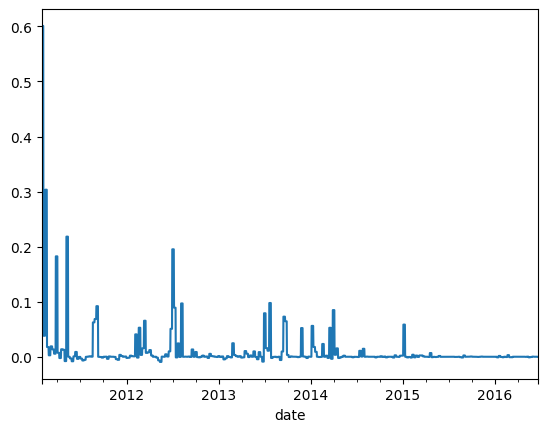

In [122]:
get_price('HOBBIES_1', 'CA_1').resample('D').mean().plot()

<AxesSubplot: xlabel='d'>

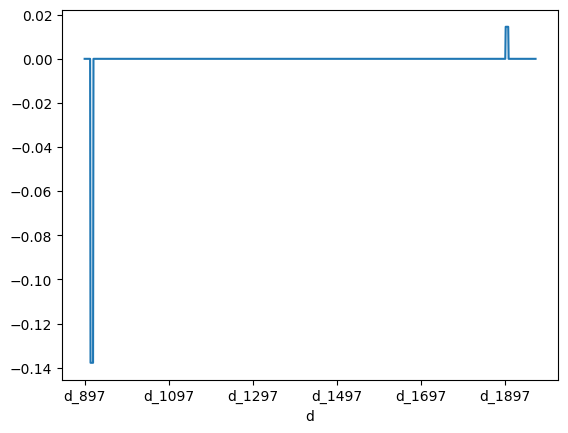

In [80]:
get_price('HOBBIES_1_001', 'CA_1').plot()

In [5]:
exp_var = calendar[['date', 'd', 'weekday', 'event_type_1', 'event_type_2', 'snap_CA', 'snap_TX', 'snap_WI']].copy()
exp_var.fillna('No_event', inplace = True)

dummies = pd.get_dummies(\
    exp_var[['event_type_1', 'event_type_2', 'weekday']])

for i in dummies.columns:
    a = f"{i}"
    exp_var[a] = dummies[a]

exp_var = exp_var.drop(['event_type_1', 'event_type_2', 'event_type_1_No_event', 'event_type_2_No_event', 'weekday',\
                        'weekday_Wednesday'], axis = 1)

In [6]:
exp_var

,date,d,snap_CA,snap_TX,snap_WI,event_type_1_Cultural,event_type_1_National,event_type_1_Religious,event_type_1_Sporting,event_type_2_Cultural,event_type_2_Religious,weekday_Friday,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday
0,2011-01-29,d_1,0,0,0,False,False,False,False,False,False,False,False,True,False,False,False
1,2011-01-30,d_2,0,0,0,False,False,False,False,False,False,False,False,False,True,False,False
2,2011-01-31,d_3,0,0,0,False,False,False,False,False,False,False,True,False,False,False,False
3,2011-02-01,d_4,1,1,0,False,False,False,False,False,False,False,False,False,False,False,True
4,2011-02-02,d_5,1,0,1,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1964,2016-06-15,d_1965,0,1,1,False,False,False,False,False,False,False,False,False,False,False,False
1965,2016-06-16,d_1966,0,0,0,False,False,False,False,False,False,False,False,False,False,True,False
1966,2016-06-17,d_1967,0,0,0,False,False,False,False,False,False,True,False,False,False,False,False
1967,2016-06-18,d_1968,0,0,0,False,False,False,False,False,False,False,False,True,False,False,False
